# Object Detection

- https://github.com/matterport/Mask_RCNN
- https://github.com/pytorch/vision/tree/main/torchvision/models/detection

## Balloon Dataset

In [ ]:
import os
import requests
import zipfile
import shutil

url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
filename = "balloon_dataset.zip"

# Check if the file already exists
if not os.path.exists(filename):
    # Download the file if it does not exist
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded {filename}")
else:
    print(f"{filename} already exists. Skipping download.")

# Extract the zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()
    print(f"Extracted {filename}")

# Remove the __MACOSX directory if it exists
if os.path.exists("__MACOSX"):
    shutil.rmtree("__MACOSX")
    print("Removed __MACOSX directory")

Downloaded balloon_dataset.zip
Extracted balloon_dataset.zip
Removed __MACOSX directory


Extracted balloon_dataset.zip
Removed __MACOSX directory


## Convert to COCO format

In [ ]:
import cv2
import os
import json
import numpy as np

def calculate_area(poly):
    # poly is a flat list of coordinates [x1, y1, x2, y2, ...]
    x = poly[0::2]  # x-coordinates
    y = poly[1::2]  # y-coordinates
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    a_idx = 0
    dataset_dicts = {'images':[], 'annotations':[], 'categories':[{
        "id" : 1,
        "name" : "balloon"
    }]}
    for idx, v in enumerate(imgs_anns.values()):
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        dataset_dicts['images'].append({
            'id': int(idx),
            'width': width,
            'height': height,
            'file_name': v["filename"]
        })
      
        annos = v["regions"]
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            X = int(np.min(px))
            Y = int(np.min(py))
            H = int(np.max(py)) - Y
            W = int(np.max(px)) - X
            
            obj = {
                "bbox": [X, Y, W, H],
                "segmentation": [poly],
                "area": calculate_area(poly),
                "category_id": 1,
                "image_id": int(idx),
                "id": int(a_idx),
                "iscrowd": 0
            }
            dataset_dicts['annotations'].append(obj)
            a_idx += 1
    return dataset_dicts

In [ ]:
train_dicts = get_balloon_dicts("balloon/train")
val_dicts = get_balloon_dicts("balloon/val")

In [ ]:
def save_json(dicts, file):
    with open(file, 'wt', encoding='UTF-8') as coco:
        json.dump(dicts, coco, indent=2, sort_keys=True)

In [ ]:
save_json(train_dicts, "balloon/train.json")
save_json(val_dicts, "balloon/val.json")

## Images, Annotations

In [ ]:
from pathlib import Path

In [ ]:
root = "balloon"

In [ ]:
root = Path(root)
train_img = root / "train"
val_img = root / "val"

train_ann = root / "train.json"
val_ann = root / "val.json"

In [ ]:
train_img, train_ann

(WindowsPath('balloon/train'), WindowsPath('balloon/train.json'))

In [ ]:
val_img, val_ann

(WindowsPath('balloon/val'), WindowsPath('balloon/val.json'))

## COCODetection dataset

In [ ]:
import torch
import torchvision.transforms.v2 as T
from torchvision import tv_tensors

class DetectionPresetTrain:
    def __init__(self, data_augmentation="hflip", hflip_prob=0.5):
    
        transforms = []
    
        if data_augmentation == "hflip":
            transforms += [T.RandomHorizontalFlip(p=hflip_prob)]
    
        transforms += [T.ToImage()]
        transforms += [T.ToDtype(torch.float, scale=True)]
        
        transforms += [
            T.ConvertBoundingBoxFormat(tv_tensors.BoundingBoxFormat.XYXY),
            T.SanitizeBoundingBoxes(),
            T.ToPureTensor()
        ]
        
        self.transforms = T.Compose(transforms)

    def __call__(self, img, target):
        return self.transforms(img, target)

class DetectionPresetEval:
    def __init__(self):

        transforms = []

        transforms += [T.ToImage()]
        transforms += [T.ToDtype(torch.float, scale=True)]

        transforms += [T.ToPureTensor()]

        self.transforms = T.Compose(transforms)

    def __call__(self, img, target):
        return self.transforms(img, target)

In [ ]:
from torchvision import datasets

In [ ]:
target_keys = ["image_id", "boxes", "labels"] # "masks" for segementation

transforms = DetectionPresetTrain()
dataset = datasets.CocoDetection(train_img, train_ann, transforms=transforms)
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys=target_keys)

eval_transforms = DetectionPresetEval()
val_dataset = datasets.CocoDetection(val_img, val_ann, transforms=eval_transforms)
val_dataset = datasets.wrap_dataset_for_transforms_v2(val_dataset, target_keys=target_keys)

print(f"Train: {len(dataset)}")
print(f"Val  : {len(val_dataset)}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train: 61
Val  : 13


## id to category

In [ ]:
coco = dataset.coco
cats = coco.loadCats(coco.getCatIds())
num_classes = sorted(coco.getCatIds())[-1] + 1   # index 0 : background
print(f"# of classes: {num_classes}")
id2cat = {cat['id']:cat['name'] for cat in cats}
id2cat

# of classes: 2


{1: 'balloon'}

## Visualization

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2 import functional as F

def plot(img, target, title=None):

    boxes = target["boxes"]
    labels = target["labels"]
    labels = [id2cat[l.item()] for l in labels]
    
    img = F.to_image(img)
    img = draw_bounding_boxes(img, boxes, 
                              colors="yellow", width=3, labels=labels)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

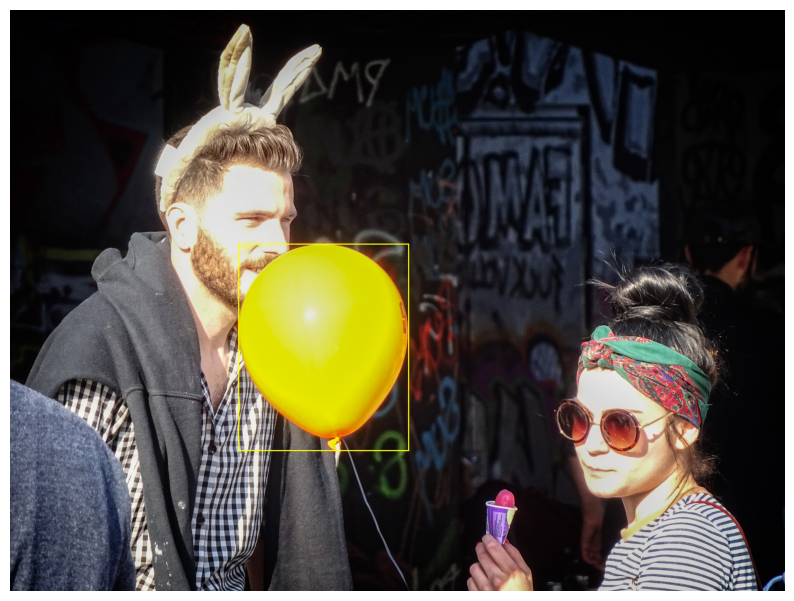

In [ ]:
plot(*dataset[0])

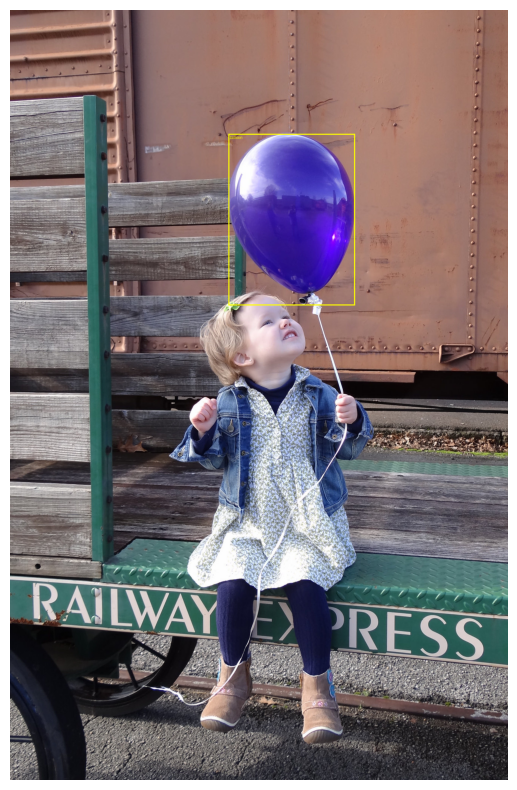

In [ ]:
plot(*val_dataset[0])

## Dataloader

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

workers = 0
batch_size = 2   # images per gpu

train_sampler = torch.utils.data.RandomSampler(dataset)
train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, batch_size, drop_last=True)

val_sampler = torch.utils.data.SequentialSampler(val_dataset)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_sampler=train_batch_sampler, num_workers=workers, collate_fn=collate_fn
)

val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, sampler=val_sampler, num_workers=workers, collate_fn=collate_fn
)

## Model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
model_name = "fasterrcnn_resnet50_fpn"
weights = 'FasterRCNN_ResNet50_FPN_Weights.COCO_V1'
# weights = None
weights_backbone = 'ResNet50_Weights.IMAGENET1K_V1'

model = torchvision.models.get_model(
    model_name, weights=weights, weights_backbone=weights_backbone,
)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\user/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████| 160M/160M [00:14<00:00, 11.4MB/s]


In [ ]:
from torchinfo import summary

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
FasterRCNN                                              --
├─GeneralizedRCNNTransform: 1-1                         --
├─BackboneWithFPN: 1-2                                  --
│    └─IntermediateLayerGetter: 2-1                     --
│    │    └─Conv2d: 3-1                                 (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      --
│    │    └─ReLU: 3-3                                   --
│    │    └─MaxPool2d: 3-4                              --
│    │    └─Sequential: 3-5                             (212,992)
│    │    └─Sequential: 3-6                             1,212,416
│    │    └─Sequential: 3-7                             7,077,888
│    │    └─Sequential: 3-8                             14,942,208
│    └─FeaturePyramidNetwork: 2-2                       --
│    │    └─ModuleList: 3-9                             984,064
│    │    └─ModuleList: 3-10                            2,360,320
│    

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model = model.to(device)

## Evaulator

In [ ]:
import numpy as np
import copy
import io
from contextlib import redirect_stdout
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def evaluate_imgs(imgs):
    with redirect_stdout(io.StringIO()):
        imgs.evaluate()
    return imgs.params.imgIds, np.asarray(imgs.evalImgs).reshape(-1, len(imgs.params.areaRng), len(imgs.params.imgIds))
    
class CocoEvaluator:
    def __init__(self, coco_gt, iou_types):
        if not isinstance(iou_types, (list, tuple)):
            raise TypeError(f"This constructor expects iou_types of type list or tuple, instead  got {type(iou_types)}")
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            with redirect_stdout(io.StringIO()):
                coco_dt = COCO.loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate_imgs(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print(f"IoU metric: {iou_type}")
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

def get_coco_api_from_dataset(dataset):
    return dataset.coco

def _get_iou_types(model):
    iou_types = ["bbox"]
    return iou_types

def evaluate(model, data_loader, device):
    cpu_device = torch.device("cpu")
    model.eval()

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    print_freq = 1
    for sample_idx, (images, targets) in enumerate(data_loader):
        if sample_idx % print_freq == 0:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
            res = {target["image_id"]: output for target, output in zip(targets, outputs)}
            coco_evaluator.update(res)
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator

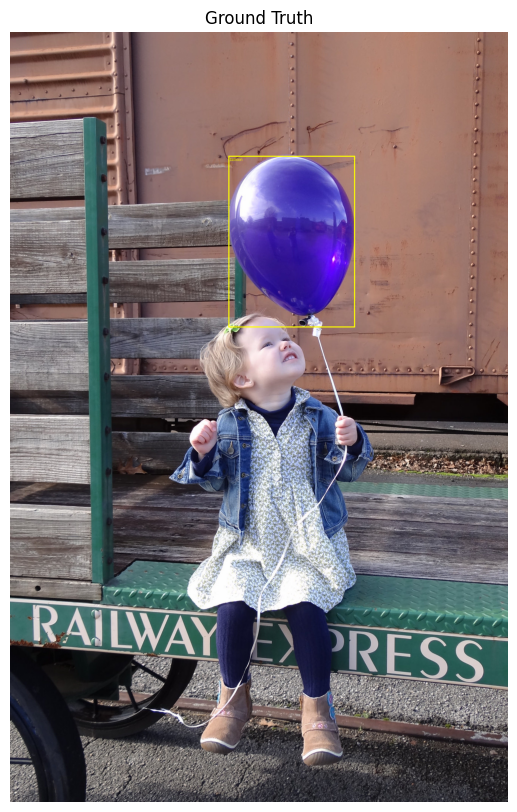

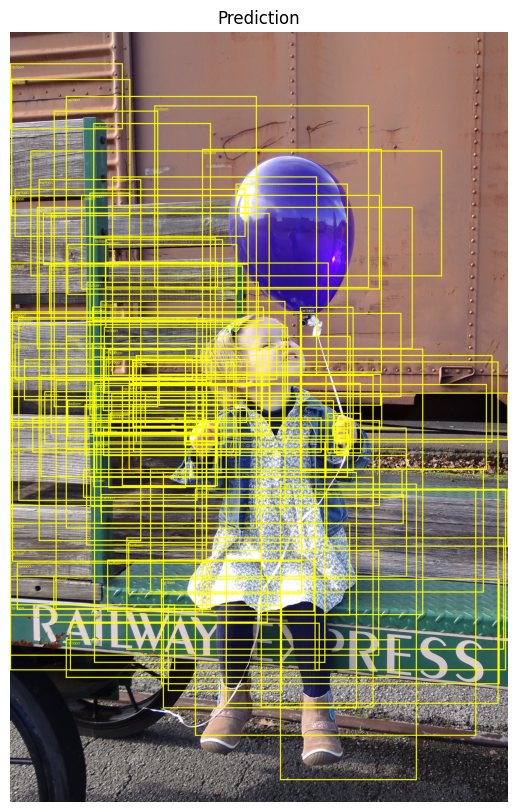

In [ ]:
with torch.inference_mode():    
    images, targets = next(iter(val_data_loader))
    images = list(img.to(device) for img in images)
    plot(images[0], targets[0], "Ground Truth")

    model.eval()
    score_thres = 0.5
    cpu_device = "cpu"
    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    outs = {}
    score_criterion = outputs[0]['scores'] > score_thres
    outs['boxes'] = outputs[0]['boxes'][score_criterion]
    outs['labels'] = outputs[0]['labels'][score_criterion]
    plot(images[0].to(cpu_device), outs, "Prediction")

In [ ]:
evaluate(model, val_data_loader, device=device)

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

<__main__.CocoEvaluator>

## Train

In [ ]:
parameters = [p for p in model.parameters() if p.requires_grad]

In [ ]:
opt_name = "sgd"
lr = 0.00025
# lr = 1e-5
momentum=0.9
weight_decay=0.0001

if opt_name.startswith("sgd"):
    optimizer = torch.optim.SGD(
        parameters,
        lr = lr,
        momentum = momentum,
        weight_decay = weight_decay,
        nesterov = "nesterov" in opt_name,
    )
elif opt_name == "adamw":
    optimizer = torch.optim.AdamW(
        parameters, 
        lr = lr,
        weight_decay = weight_decay
    )

In [ ]:
import math
import sys

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()

    for sample_idx, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        if sample_idx % print_freq == 0:
            print(f"Epoch: [{epoch}]", end=' ')
            print(f"[{sample_idx}/{len(data_loader)}]", end=' ')
            print(f"loss: {loss_value:.4f}", end=' ')
            for k, v in loss_dict.items():
                if isinstance(v, torch.Tensor):
                    v = v.item()
                print(f"{k}: {v:.4f}", end=' ')
            print()
                

In [ ]:
output_dir = './output-pytorch'
Path(output_dir).mkdir(exist_ok=True, parents=True)

start_epoch = 0
epochs = 5
print_freq = 5

import sys
import datetime
import time
import os

start_time = time.time()

for epoch in range(start_epoch, epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq)
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
    }
    torch.save(checkpoint, os.path.join(output_dir, f"model_{epoch}.pth"))
    torch.save(checkpoint, os.path.join(output_dir, "checkpoint.pth"))

    evaluate(model, val_data_loader, device=device)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")

Epoch: [0] [0/30] loss: 1.3383 loss_classifier: 0.4481 loss_box_reg: 0.2616 loss_objectness: 0.6006 loss_rpn_box_reg: 0.0279 
Epoch: [0] [5/30] loss: 1.0487 loss_classifier: 0.4750 loss_box_reg: 0.5489 loss_objectness: 0.0181 loss_rpn_box_reg: 0.0067 
Epoch: [0] [10/30] loss: 0.5723 loss_classifier: 0.3094 loss_box_reg: 0.2481 loss_objectness: 0.0137 loss_rpn_box_reg: 0.0011 
Epoch: [0] [15/30] loss: 0.6002 loss_classifier: 0.2591 loss_box_reg: 0.2106 loss_objectness: 0.1297 loss_rpn_box_reg: 0.0008 
Epoch: [0] [20/30] loss: 0.9539 loss_classifier: 0.3143 loss_box_reg: 0.5178 loss_objectness: 0.1038 loss_rpn_box_reg: 0.0180 
Epoch: [0] [25/30] loss: 0.2890 loss_classifier: 0.1020 loss_box_reg: 0.1848 loss_objectness: 0.0017 loss_rpn_box_reg: 0.0005 
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.834
 Average Pre

## Evaluate

In [ ]:
CHECKPOINT = torch.load(os.path.join(output_dir, "checkpoint.pth"), weights_only=True)["model"]

new_model = torchvision.models.get_model(
    model_name, weights=None, weights_backbone=None,
)
in_features = new_model.roi_heads.box_predictor.cls_score.in_features
new_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
new_model.load_state_dict(CHECKPOINT)
new_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
evaluate(new_model, val_data_loader, device=device)

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

<__main__.CocoEvaluator>

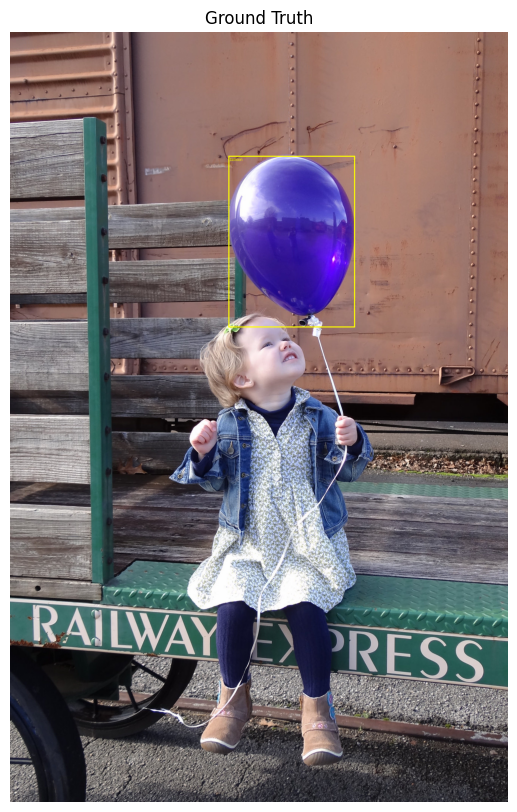

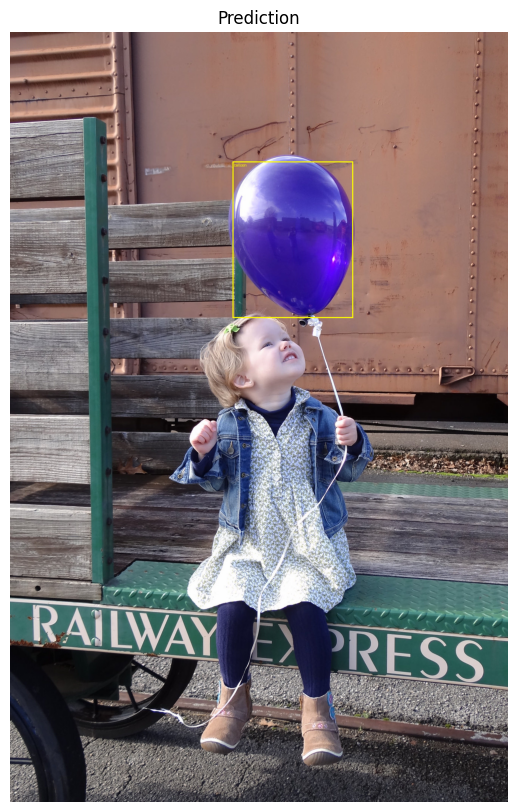

In [ ]:
with torch.inference_mode():    
    images, targets = next(iter(val_data_loader))
    images = list(img.to(device) for img in images)
    plot(images[0], targets[0], "Ground Truth")

    new_model.eval()
    score_thres = 0.5
    cpu_device = "cpu"
    outputs = new_model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    outs = {}
    score_criterion = outputs[0]['scores'] > score_thres
    outs['boxes'] = outputs[0]['boxes'][score_criterion]
    outs['labels'] = outputs[0]['labels'][score_criterion]
    plot(images[0].to(cpu_device), outs, "Prediction")